In [6]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit
import pickle

---

In [7]:
#First we read collected and already cleaned data
#marburg = pd.read_csv("../data_0/marburg.csv")
#duisburg = pd.read_csv("../data_0/duisburg.csv")
#marburg_weather = pd.read_csv("../data_0/weather/marburg_weather.csv")
#duisburg_weather = pd.read_csv("../data_0/weather/duisburg_weather.csv")

# KPIs

## Utilization / Peak Utilization (Anne)

### Marburg

In [8]:
#Read in data
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
fleet_size = len(marburg["b_number"].unique())
marburg
kpi_mar = pd.DataFrame()

In [9]:
#setting start and end date of the trips (start is rounded down hourly)
marburg["start"] = marburg.index.floor(freq = "H")
marburg['end'] = marburg.index + pd.to_timedelta(marburg['trip_duration_mins'], unit='m')
marburg

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,start,end
datetime,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,2019-07-04 13:00:00,2019-07-04 14:10:00
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,2019-07-06 16:00:00,2019-07-06 17:12:00
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,2019-07-06 17:00:00,2019-07-06 18:19:00
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,2019-07-06 20:00:00,2019-07-06 20:41:00
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,2019-07-07 08:00:00,2019-07-07 08:59:00
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19 12:57:00,2019-05-19,12:57:00,91116,marburg,"(50.8279, 8.7751)","(50.8137, 8.7707)",6,12,20,2019-05-19 12:00:00,2019-05-19 13:17:00
2019-05-19 21:41:00,2019-05-19,21:41:00,91116,marburg,"(50.8137, 8.7707)","(50.8229, 8.7747)",6,21,7,2019-05-19 21:00:00,2019-05-19 21:48:00
2019-05-20 06:56:00,2019-05-20,06:56:00,91116,marburg,"(50.8229, 8.7747)","(50.82, 8.7737)",0,6,3,2019-05-20 06:00:00,2019-05-20 06:59:00


In [10]:
#computing availablility by grouping by datetime and checking the number of diiferent bike numbers
kpi_mar["util"]  = marburg.groupby("start")["b_number"].nunique()
kpi_mar["util"]

start
2019-01-20 00:00:00     6
2019-01-20 01:00:00     8
2019-01-20 02:00:00     5
2019-01-20 03:00:00     1
2019-01-20 04:00:00     2
                       ..
2020-01-20 19:00:00    30
2020-01-20 20:00:00    25
2020-01-20 21:00:00    15
2020-01-20 22:00:00     9
2020-01-20 23:00:00     4
Name: util, Length: 8345, dtype: int64

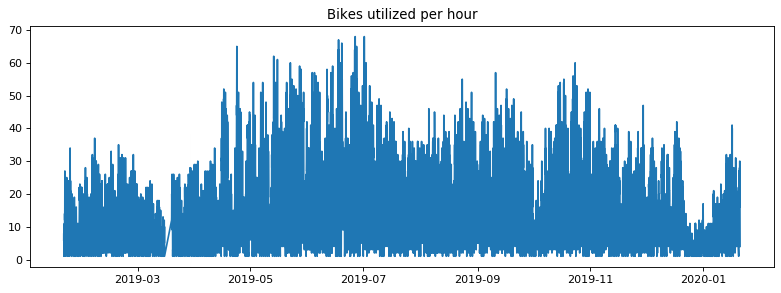

In [11]:
#plotting availability
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_mar["util"])
ax.set_title("Bikes utilized per hour")
plt.show()

In [12]:
#creating day column
kpi_mar["date"] = kpi_mar.index.date
kpi_mar

,util,date
start,,
2019-01-20 00:00:00,6,2019-01-20
2019-01-20 01:00:00,8,2019-01-20
2019-01-20 02:00:00,5,2019-01-20
2019-01-20 03:00:00,1,2019-01-20
2019-01-20 04:00:00,2,2019-01-20
...,...,...
2020-01-20 19:00:00,30,2020-01-20
2020-01-20 20:00:00,25,2020-01-20
2020-01-20 21:00:00,15,2020-01-20


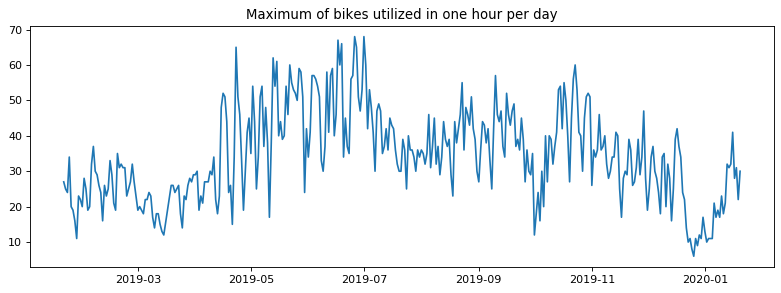

In [13]:
#computing max availaibility per day and plotting it
max_avail = kpi_mar.groupby("date")["util"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail)
ax.set_title("Maximum of bikes utilized in one hour per day")
plt.show()

### Duisburg

In [14]:
#Read in data
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
fleet_size = len(duisburg["b_number"].unique())
duisburg
kpi_duis = pd.DataFrame()

In [15]:
#setting start and end date of the trips (start is rounded down hourly)
duisburg["start"] = duisburg.index.floor(freq = "H")
duisburg['end'] = duisburg.index + pd.to_timedelta(duisburg['trip_duration_mins'], unit='m')
duisburg

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,start,end
datetime,,,,,,,,,,,
2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,2019-05-27 14:00:00,2019-05-27 16:01:00
2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,2019-05-27 17:00:00,2019-05-27 18:04:00
2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,2019-05-28 08:00:00,2019-05-28 08:25:00
2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,2019-06-04 09:00:00,2019-06-04 09:25:00
2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,2019-06-05 09:00:00,2019-06-05 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20 07:14:00,2020-01-20,07:14:00,501597,duisburg,"(51.4273, 6.7978)","(51.4294, 6.7772)",0,7,21,2020-01-20 07:00:00,2020-01-20 07:35:00
2020-01-20 10:08:00,2020-01-20,10:08:00,501597,duisburg,"(51.4294, 6.7772)","(51.4284, 6.8004)",0,10,10,2020-01-20 10:00:00,2020-01-20 10:18:00
2020-01-20 19:39:00,2020-01-20,19:39:00,501597,duisburg,"(51.4284, 6.8004)","(51.4294, 6.7772)",0,19,11,2020-01-20 19:00:00,2020-01-20 19:50:00


In [16]:
#computing availablility by grouping by datetime and checking the number of diiferent bike numbers
kpi_duis["util"]  = duisburg.groupby("start")["b_number"].nunique()
kpi_duis["util"]

start
2019-01-20 00:00:00     1
2019-01-20 01:00:00     3
2019-01-20 05:00:00     1
2019-01-20 06:00:00     4
2019-01-20 07:00:00     1
                       ..
2020-01-20 19:00:00    14
2020-01-20 20:00:00    15
2020-01-20 21:00:00    10
2020-01-20 22:00:00     5
2020-01-20 23:00:00     4
Name: util, Length: 8288, dtype: int64

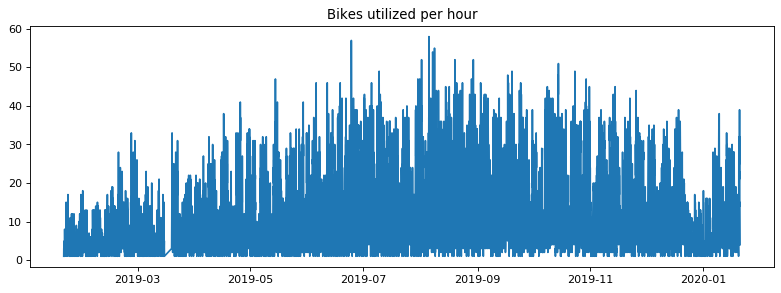

In [17]:
#plotting availability
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_duis["util"])
ax.set_title("Bikes utilized per hour")
plt.show()

In [18]:
#creating day column
kpi_duis["date"] = kpi_duis.index.date
kpi_duis

,util,date
start,,
2019-01-20 00:00:00,1,2019-01-20
2019-01-20 01:00:00,3,2019-01-20
2019-01-20 05:00:00,1,2019-01-20
2019-01-20 06:00:00,4,2019-01-20
2019-01-20 07:00:00,1,2019-01-20
...,...,...
2020-01-20 19:00:00,14,2020-01-20
2020-01-20 20:00:00,15,2020-01-20
2020-01-20 21:00:00,10,2020-01-20


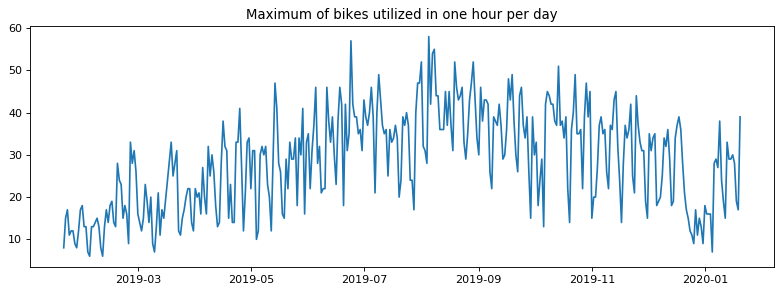

In [19]:
#computing max availaibility per day and plotting it
max_avail = kpi_duis.groupby("date")["util"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail)
ax.set_title("Maximum of bikes utilized in one hour per day")
plt.show()

## Fleet distance traveled (Tim)

Wer das hier liest ist cool :)

## Quality of fleet (Julia)

Another key performance indicator is the quality of the bikes.   
We can assume that if a bike is'nt used for 1 week or longer it is probably broken or can't be accessed.
The percentage of bikes that overstep this threshold value can tells us the quality of the fleet.

In [20]:
kpi_mar

,util,date
start,,
2019-01-20 00:00:00,6,2019-01-20
2019-01-20 01:00:00,8,2019-01-20
2019-01-20 02:00:00,5,2019-01-20
2019-01-20 03:00:00,1,2019-01-20
2019-01-20 04:00:00,2,2019-01-20
...,...,...
2020-01-20 19:00:00,30,2020-01-20
2020-01-20 20:00:00,25,2020-01-20
2020-01-20 21:00:00,15,2020-01-20


## Spread of fleet / coverage (Moritz)